<a href="https://colab.research.google.com/github/panghanwu/tibame_project/blob/main/resnet50_face_gender_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [ ]:
import glob

glob.glob('drive/MyDrive/Datasets/UTKFace/face_crop/*')

['drive/MyDrive/Datasets/UTKFace/face_crop/male',
 'drive/MyDrive/Datasets/UTKFace/face_crop/female']

In [ ]:
import pandas as pd
import os

# survey data
img_dir = glob.glob('drive/MyDrive/Datasets/UTKFace/face_crop/*')
img_path = []
img_class = []
class_code = []

for code, dir in enumerate(img_dir):
    img_list = glob.glob(dir + '/*')
    cls = os.path.split(dir)[-1]

    for img in img_list:
        img_path.append(img)
        img_class.append(cls)
        class_code.append(code)


data = {
    'img_path': img_path,
    'img_class': img_class,
    'class_code': class_code
}

img_df = pd.DataFrame(data)

img_df

,img_path,img_class,class_code
0,drive/MyDrive/Datasets/UTKFace/face_crop/male/...,male,0
1,drive/MyDrive/Datasets/UTKFace/face_crop/male/...,male,0
2,drive/MyDrive/Datasets/UTKFace/face_crop/male/...,male,0
3,drive/MyDrive/Datasets/UTKFace/face_crop/male/...,male,0
4,drive/MyDrive/Datasets/UTKFace/face_crop/male/...,male,0
...,...,...,...
24100,drive/MyDrive/Datasets/UTKFace/face_crop/femal...,female,1
24101,drive/MyDrive/Datasets/UTKFace/face_crop/femal...,female,1
24102,drive/MyDrive/Datasets/UTKFace/face_crop/femal...,female,1
24103,drive/MyDrive/Datasets/UTKFace/face_crop/femal...,female,1


In [ ]:
from sklearn.model_selection import train_test_split

x_tra, x_val, y_tra, y_val = train_test_split(img_path, class_code, test_size=.25)
print(len(x_tra), len(x_val), len(y_tra), len(y_val))

18078 6027 18078 6027


# Data Loader

In [ ]:
from PIL import Image
from torchvision import transforms
import numpy as np
import torch

# augmentation
tra_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=10
    ),
    transforms.Resize(224),
    transforms.GaussianBlur(3, sigma=(.1, 1.0)),
    transforms.ColorJitter(
        brightness=.1,
        contrast=.1,
        saturation=.1,
        hue=.1
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]
    )
])

# validation resize
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]
        )
])



In [ ]:
from torch.utils.data.dataset import Dataset

# dataset
class MyDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms


    def __getitem__(self, index):
        path = self.img_path_list[index]
        img = Image.open(path)
        img = img.convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        
        label = self.label_list[index]

        return (img, label)

    def __len__(self):
        return len(self.img_path_list)

train_dataset = MyDataset(
    x_tra,
    y_tra,
    tra_transform
)

valid_dataset = MyDataset(
    x_val,
    y_val,
    val_transform
)

print(len(train_dataset), len(valid_dataset))

18078 6027


In [ ]:
from torch.utils.data import DataLoader

# data loader
train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4
)

# next(iter(train_loader))

## View images

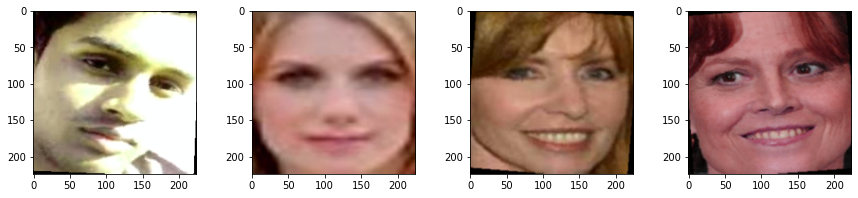

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def tenor2img(inp):
    mean = np.array([.485,.456,.406])
    std  = np.array([.229,.224,.225])

    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

# get one batch
images, labels = next(iter(train_loader))

# plot
n = images.shape[0]
plt.figure(figsize=(15,3))

for i in range(n):
    plt.subplot(1, 4, i+1)

    img = tenor2img(images[i])
    plt.imshow(img)

plt.show()

## Set GPU

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('GPU:', torch.cuda.is_available())

GPU: True


## Set transferred model

In [ ]:
from torchvision import models

# ResNet
my_model = models.resnet50(pretrained=True)

In [ ]:
from torch import nn, optim

num_ftrs = my_model.fc.in_features

# set output to number of classes
my_model.fc = nn.Linear(num_ftrs, 2)

my_model = my_model.to(device)

# config
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=.1)

my_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Fuction

In [ ]:
import time
import copy

#TODO count time in each epoch

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = .0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-' * 10)

        # training
        # set model to training mode
        model.train()

        running_loss = .0
        running_corrects = 0

        for input, label in train_loader:
            # print('good')
            input = input.to(device)
            label = label.to(device)
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                output = model(input)
                _, preds = torch.max(output, 1)
                loss = criterion(output, label)

                # backward
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * input.size(0)
            running_corrects += torch.sum(preds==label.data)
        
        scheduler.step()
        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = running_corrects.double() / len(train_dataset)
        print('[train] Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_accuracy), end='  ')

        # validation
        model.eval()

        running_loss = .0
        running_corrects = 0

        for input, label in valid_loader:
            input = input.to(device)
            label = label.to(device)
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(False):
                output = model(input)
                _, preds = torch.max(output, 1)
                loss = criterion(output, label)

            # statistics
            running_loss += loss.item() * input.size(0)
            running_corrects += torch.sum(preds==label.data)

        epoch_loss = running_loss / len(valid_dataset)
        epoch_accuracy = running_corrects.double() / len(valid_dataset)
        print('[valid] Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_accuracy))

        # save model 
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'resnet50_face_gender.pt')
    
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_accuracy))

    # load best model weights
    model.load_state_dict(best_model)
    
    return model


## Train model

In [ ]:
my_model = train_model(my_model, criterion, optimizer, scheduler, num_epochs=100)

Epoch 0/99
----------
[train] Loss: 0.4463 Acc: 0.7947  [valid] Loss: 0.2684 Acc: 0.8824

Epoch 1/99
----------
[train] Loss: 0.2799 Acc: 0.8789  [valid] Loss: 0.2324 Acc: 0.9051

Epoch 2/99
----------
[train] Loss: 0.2393 Acc: 0.8990  [valid] Loss: 0.2230 Acc: 0.9087

Epoch 3/99
----------
[train] Loss: 0.2197 Acc: 0.9050  [valid] Loss: 0.1990 Acc: 0.9170

Epoch 4/99
----------
[train] Loss: 0.2033 Acc: 0.9156  [valid] Loss: 0.2062 Acc: 0.9127

Epoch 5/99
----------
[train] Loss: 0.1887 Acc: 0.9232  [valid] Loss: 0.1870 Acc: 0.9219

Epoch 6/99
----------
[train] Loss: 0.1744 Acc: 0.9298  [valid] Loss: 0.2032 Acc: 0.9199

Epoch 7/99
----------
[train] Loss: 0.1290 Acc: 0.9506  [valid] Loss: 0.1782 Acc: 0.9326

Epoch 8/99
----------
[train] Loss: 0.1144 Acc: 0.9577  [valid] Loss: 0.1743 Acc: 0.9356

Epoch 9/99
----------
[train] Loss: 0.1034 Acc: 0.9623  [valid] Loss: 0.1781 Acc: 0.9338

Epoch 10/99
----------
[train] Loss: 0.0967 Acc: 0.9651  [valid] Loss: 0.1866 Acc: 0.9358

Epoch 11/

KeyboardInterrupt: ignored